In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn import metrics

# Classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

In [172]:
# Read the dataset into dataframe 
d = pd.read_csv('bank.csv',sep=',')

In [173]:
# check for data type
# Replace the target variable into quantifiable output
d.y.replace({'no':0,'yes':1},inplace=True) 
d.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [4]:
# check Null values, If there exist any null values we either replace it by mean, median or mode.
d.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

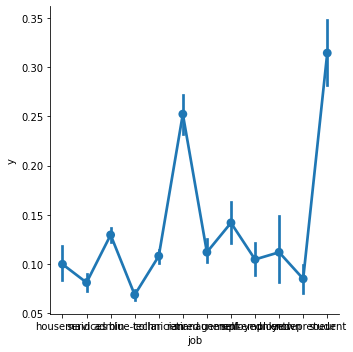

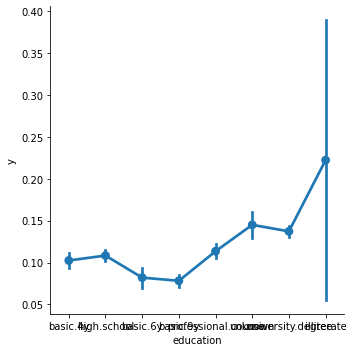

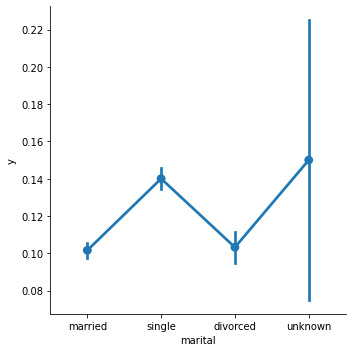

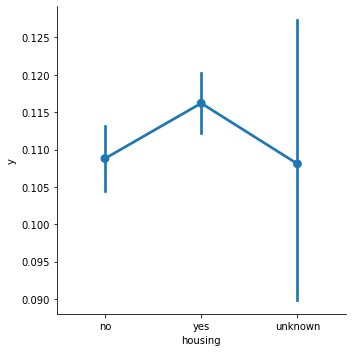

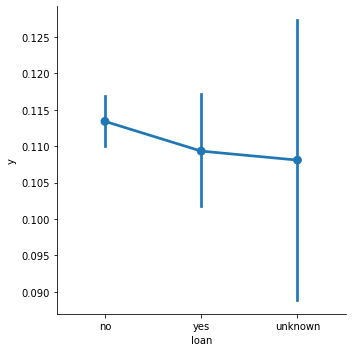

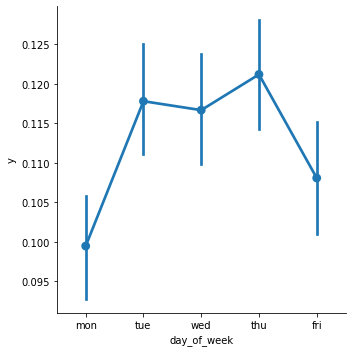

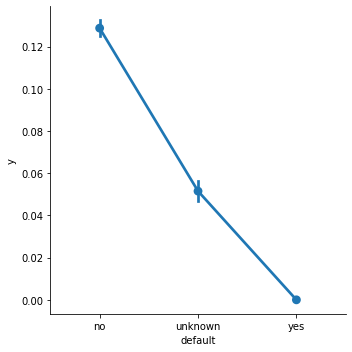

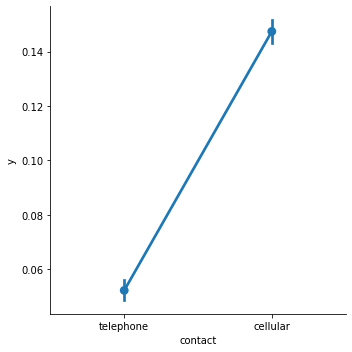

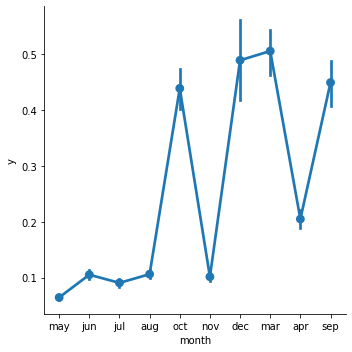

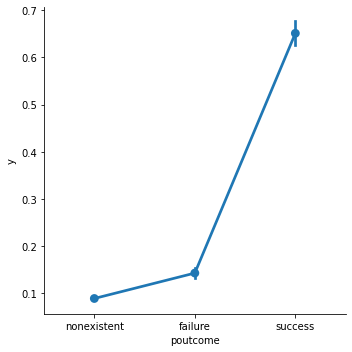

In [197]:
# Understand how non numeric attributes getting impacted by the target variable
non_numeric_variable = ["job","education","marital","housing","loan","day_of_week","default","contact","month","poutcome"]
for index,variable in enumerate(non_numeric_variable):
    sns.catplot(x=variable, y="y",kind='point', data=d, orient='v')


In [10]:
# Categories using one hot encoding
d = pd.get_dummies(d, columns=['job'], prefix = ['j_'])
d = pd.get_dummies(d, columns=['education'], prefix = ['e_'])
d = pd.get_dummies(d, columns=['marital'], prefix = ['m_'])
d = pd.get_dummies(d, columns=['housing'], prefix = ['h_'])
d = pd.get_dummies(d, columns=['loan'], prefix = ['l_'])
d = pd.get_dummies(d, columns=['day_of_week'], prefix = ['d_'])
d = pd.get_dummies(d, columns=['default'], prefix = ['de_'])
d = pd.get_dummies(d, columns=['contact'], prefix = ['c_'])

# Categories using Labels
dict_month ={'may':1, 'jun':5,'jul':2, 'aug':4,'oct':8, 'nov':3, 'dec':9, 'mar':10,'apr':6,'sep':7}
for row in d.itertuples(index=True):
    d.at[row.Index,'month'] = dict_month[row.month]

dict_outcome ={'nonexistent':1, 'failure':2,'success':5}
for row in d.itertuples(index=True):
    d.at[row.Index,'poutcome'] = dict_outcome[row.poutcome]


In [13]:
# Form new Attributes if possible
d['reachability'] = d['campaign']*d['previous']
d['spendability']= (d['cons.price.idx']* d['cons.conf.idx']) / d['emp.var.rate']
d['product_quality']  = d['poutcome']* d['cons.conf.idx']*d['duration']

In [14]:
d

,age,month,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,...,d__tue,d__wed,de__no,de__unknown,de__yes,c__cellular,c__telephone,reachability,spendability,product_quality
0,56,1,261,1,999,0,1,1.1,93.994,-36.4,...,0,0,1,0,0,0,1,0,-3110.346909,-9500.4
1,57,1,149,1,999,0,1,1.1,93.994,-36.4,...,0,0,0,1,0,0,1,0,-3110.346909,-5423.6
2,37,1,226,1,999,0,1,1.1,93.994,-36.4,...,0,0,1,0,0,0,1,0,-3110.346909,-8226.4
3,40,1,151,1,999,0,1,1.1,93.994,-36.4,...,0,0,1,0,0,0,1,0,-3110.346909,-5496.4
4,56,1,307,1,999,0,1,1.1,93.994,-36.4,...,0,0,1,0,0,0,1,0,-3110.346909,-11174.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,3,334,1,999,0,1,-1.1,94.767,-50.8,...,0,0,1,0,0,1,0,0,4376.512364,-16967.2
41184,46,3,383,1,999,0,1,-1.1,94.767,-50.8,...,0,0,1,0,0,1,0,0,4376.512364,-19456.4
41185,56,3,189,2,999,0,1,-1.1,94.767,-50.8,...,0,0,1,0,0,1,0,0,4376.512364,-9601.2
41186,44,3,442,1,999,0,1,-1.1,94.767,-50.8,...,0,0,1,0,0,1,0,0,4376.512364,-22453.6


### Pipeline the Below Processes
>(1) The training and test set are created. <br>
>(2) Features are then scaled via Z-score normalization.   <br>
>(3) A feature selection algorithm to reduce the number of features.   <br>
>(4) Predictive Models

Train and tune 17 classifiers and evaluate their performance using the area under the receiver operating curve (AUC)

In [16]:
# Splitting the dataset into train and test
X = d.drop(['y'],axis='columns')
y = d.y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,random_state = 1000)

In [33]:
# Created Dictionaries for different classifiers
classifiers = {
"LDA": LinearDiscriminantAnalysis(),
"QDA": QuadraticDiscriminantAnalysis(),
"AdaBoost": AdaBoostClassifier(),
"Bagging": BaggingClassifier(),
"Extra Trees Ensemble": ExtraTreesClassifier(),
"Gradient Boosting": GradientBoostingClassifier(),
"Random Forest": RandomForestClassifier(),
"Ridge": RidgeClassifier(),
"SGD": SGDClassifier(),
"BNB": BernoulliNB(),
"GNB": GaussianNB(),
"KNN": KNeighborsClassifier(),
"MLP": MLPClassifier(),
"LSVC": LinearSVC(),
#"NuSVC": NuSVC(),
"SVC": SVC(),
"DTC": DecisionTreeClassifier(),
"ETC": ExtraTreeClassifier()
}
DECISION_FUNCTIONS = {"Ridge", "SGD", "LSVC", "NuSVC", "SVC"}
FEATURE_IMPORTANCE = {"Gradient Boosting", "Extra Trees Ensemble", "Random Forest"}


In [36]:
### Tuning Models with different Hyper parameters
# Initiate parameter grid
parameters = {
#"NuSVC": { "classifier__nu": [0.05],"classifier__kernel": ["poly"],"classifier__degree": [6]},
"LDA": {"classifier__solver": ["svd"]},
"QDA": {"classifier__reg_param":[0.01,0.001,0.1]},
"AdaBoost": { "classifier__base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],"classifier__n_estimators": [200],"classifier__learning_rate": [0.001, 0.01, 0.1, 0.50, 1.0]},
"Bagging": { "classifier__base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],"classifier__n_estimators": [200],"classifier__max_features": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],"classifier__n_jobs": [-1]},
"Gradient Boosting": { "classifier__learning_rate":[0.01,0.001], "classifier__n_estimators": [200],"classifier__max_depth": [2,16],"classifier__min_samples_split": [0.005,0.01],"classifier__min_samples_leaf": [0.005,0.01],"classifier__max_features": ["auto"],"classifier__subsample": [0.8, 1]},
"Extra Trees Ensemble": { "classifier__n_estimators": [200],"classifier__class_weight": [None, "balanced"],"classifier__max_features": ["auto"],"classifier__max_depth" : [3, 9],"classifier__min_samples_split": [0.1, 0.01],"classifier__min_samples_leaf": [ 0.005, 0.01],"classifier__criterion" :["gini"],"classifier__n_jobs": [-1]},
"Random Forest": { "classifier__n_estimators": [200],"classifier__class_weight": [None, "balanced"],"classifier__max_features": ["auto"],"classifier__max_depth" : [8,64],"classifier__min_samples_split": [0.10,0.005],"classifier__min_samples_leaf": [ 0.005, 0.010],"classifier__criterion" :["gini"],"classifier__n_jobs": [-1]},
"Ridge": { "classifier__alpha": [1e-7, 1e-3, 0.75, 1.0]},
"SGD": { 
"classifier__alpha": [1e-7, 1e-3, 0.75, 1.0],
"classifier__penalty": ["l1", "l2"],
"classifier__n_jobs": [-1]
},
 "BNB": { 
"classifier__alpha": [1e-7, 1e-3, 0.75, 1.0]
},
 "GNB": { 
"classifier__var_smoothing": [1e-7, 1e-3, 0.75, 1.0]
},
 "KNN": { 
"classifier__n_neighbors":[5,10,20],
"classifier__p": [1, 3, 5],
"classifier__leaf_size": [5, 20, 40],
"classifier__n_jobs": [-1]
},
 "MLP": { 
"classifier__hidden_layer_sizes": [(5,5,5),(5,5,5,5,5)],
"classifier__activation": ["tanh", "relu"],
"classifier__learning_rate": [ "adaptive"],
"classifier__max_iter": [100, 1000],
"classifier__alpha": [10,1000],
},
 "LSVC": { "classifier__penalty": ["l2"],"classifier__C": [0.0001, 0.001, 0.01, 0.1, 1.0, 100]},
 "SVC": { "classifier__kernel": ["poly"],"classifier__gamma": ["auto"],"classifier__C": [100],"classifier__degree": [6]},
 "DTC": { "classifier__criterion" :["gini"],"classifier__splitter": ["best"],"classifier__class_weight": [None, "balanced"],"classifier__max_features": ["auto"],"classifier__max_depth" : [64],"classifier__min_samples_split": [0.005, 0.10],"classifier__min_samples_leaf": [0.005,0.10]},
 "ETC": { "classifier__criterion" :["gini"],"classifier__splitter": ["best"],"classifier__class_weight": [None, "balanced"],"classifier__max_features": ["auto"],"classifier__max_depth" : [64],"classifier__min_samples_split": [0.005, 0.10],"classifier__min_samples_leaf": [0.005, 0.10]}
    
}

### Feature Selection
> (1). Removing Highly Correlated features <br>
> (2). recursive feature elimination with cross 
                validation(RFECV) object only allows you to use estimators/classifiers that have feature_importances_ or coef_attributes.

### Removing Highly Correlated features

In [21]:
corr_matrix = X_train.corr(method='spearman').abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_train = X_train.drop(to_drop, axis = 1)
X_test = X_test.drop(to_drop, axis = 1)
to_drop

['h__yes', 'l__unknown', 'de__unknown', 'c__telephone', 'reachability']

### Tuning the Base estimators for Base Parameters

In [24]:
# Define classifier to use as the base of the recursive feature elimination algorithm
selected_classifier = "Random Forest"
classifier = classifiers[selected_classifier]
# Scale features via Z-score normalization
scaler = StandardScaler()
# Define steps in pipeline
steps = [("scaler", scaler), ("classifier", classifier)]
# Initialize Pipeline object
pipeline = Pipeline(steps = steps)
# Define parameter grid
param_grid = parameters[selected_classifier]
# Initialize GridSearch object
gscv = GridSearchCV(pipeline, param_grid, cv = 5,  n_jobs= -1, verbose = 1, scoring = "roc_auc")              
# Fit gscv
print(f"Now tuning {selected_classifier}. Go grab a beer or something.")
gscv.fit(X_train, np.ravel(y_train))  

Now tuning Random Forest. Go grab a beer or something.
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('classifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
           

In [26]:
best_params = gscv.best_params_
best_score = gscv.best_score_
best_score

0.9415952608341663

In [27]:
# Update classifier parameters
tuned_params = {item[12:]: best_params[item] for item in best_params}
classifier.set_params(**tuned_params)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=64, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=0.005,
                       min_samples_split=0.005, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [28]:
# Create pipeline to use RFECV
#
# Select Features using RFECV
class PipelineRFE(Pipeline):
    # Source: https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

# Define pipeline for RFECV
steps = [("scaler", scaler), ("classifier", classifier)]
pipe = PipelineRFE(steps = steps)

# Initialize RFECV object
feature_selector = RFECV(pipe, cv = 5, step = 1, scoring = "roc_auc", verbose = 1)

# Fit RFECV
feature_selector.fit(X_train, np.ravel(y_train))

# Get selected features
feature_names = X_train.columns
selected_features = feature_names[feature_selector.support_].tolist()

Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 fe

Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.


In [29]:
### visualize the results
# Get Performance Data
performance_curve = {"Number of Features": list(range(1, len(feature_names) + 1)),
                    "AUC": feature_selector.grid_scores_}
performance_curve = pd.DataFrame(performance_curve)

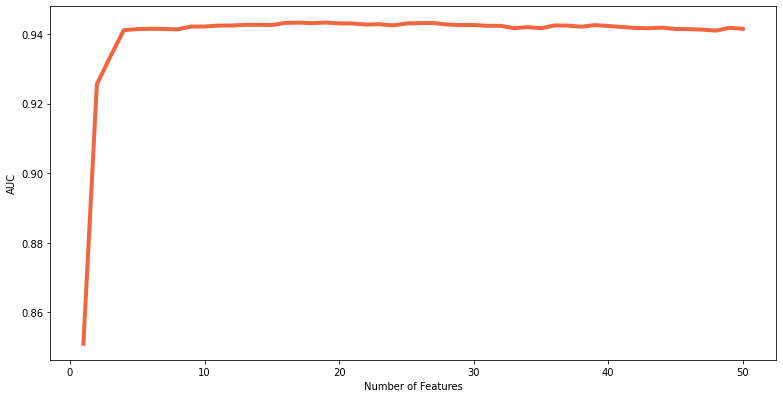

In [30]:
# Plot
colors = sns.color_palette("RdYlGn", 20)
line_color = colors[3]
f, ax = plt.subplots(figsize=(13, 6.5))
sns.lineplot(x = "Number of Features", y = "AUC", data = performance_curve,
             color = line_color, lw = 4, ax = ax)

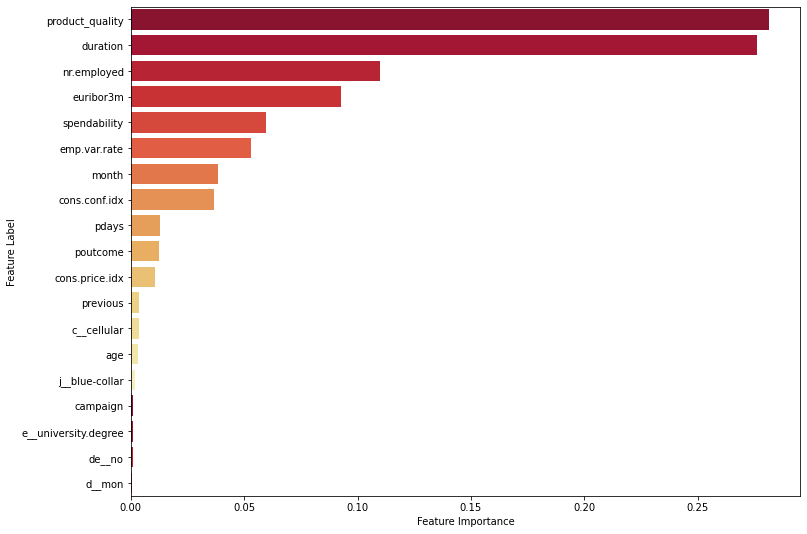

In [31]:
# Get selected features data set
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Train classifier
classifier.fit(X_train, np.ravel(y_train))
# Get feature importance
feature_importance = pd.DataFrame(selected_features, columns = ["Feature Label"])
feature_importance["Feature Importance"] = classifier.feature_importances_
# Sort by feature importance
feature_importance = feature_importance.sort_values(by="Feature Importance", ascending=False)
# Set figure size and create barplot
f, ax = plt.subplots(figsize=(12, 9))
sns.barplot(x = "Feature Importance", y = "Feature Label",
            palette = reversed(sns.color_palette('YlOrRd', 15)),  data = feature_importance)


In [37]:
# Iterative Classifier Tuning and Evaluation
# Initialize dictionary to store results
results = {}

# Tune and evaluate classifiers
for classifier_label, classifier in classifiers.items():

    print(f"Now tuning {classifier_label}.")

    # Scale features via Z-score normalization
    scaler = StandardScaler()

    # Define steps in pipeline
    steps = [("scaler", scaler), ("classifier", classifier)]

    # Initialize Pipeline object
    pipeline = Pipeline(steps = steps)

    # Define parameter grid
    param_grid = parameters[classifier_label]

    # Initialize GridSearch object
    gscv = GridSearchCV(pipeline, param_grid, cv = 5,  n_jobs= -1, verbose = 1, scoring = "roc_auc")

    # Fit gscv
    gscv.fit(X_train, np.ravel(y_train))

    # Get best parameters and score
    best_params = gscv.best_params_
    best_score = gscv.best_score_

    # Update classifier parameters and define new pipeline with tuned classifier
    tuned_params = {item[12:]: best_params[item] for item in best_params}
    classifier.set_params(**tuned_params)

    # Make predictions
    if classifier_label in DECISION_FUNCTIONS:
        y_pred = gscv.decision_function(X_test)
    else:
        y_pred = gscv.predict_proba(X_test)[:,1]

    # Evaluate model
    auc = metrics.roc_auc_score(y_test, y_pred)

    # Save results
    result ={"Classifier": gscv,
              "Best Parameters": best_params,
              "Training AUC": best_score,
              "Test AUC": auc}
    results.update({classifier_label: result})


    


Now tuning LDA.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished


Now tuning QDA.
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.2s finished


Now tuning AdaBoost.
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 10.4min finished


Now tuning Bagging.
Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  7.2min finished


Now tuning Extra Trees Ensemble.
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.2min finished


Now tuning Gradient Boosting.
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 23.0min finished


Now tuning Random Forest.
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.5min finished


Now tuning Ridge.
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.2s finished


Now tuning SGD.
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   11.5s finished


Now tuning BNB.
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.6s finished


Now tuning GNB.
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.7s finished


Now tuning KNN.
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  6.7min finished


Now tuning MLP.
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  4.2min finished


Now tuning LSVC.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   52.3s finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Now tuning SVC.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 26.6min finished


Now tuning DTC.
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.2s finished


Now tuning ETC.
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.0s finished


In [58]:
# Output the results:
# Initialize auc_score dictionary
auc_scores = {
              "Classifier": [],
              "AUC": [],
              "AUC Type": []
              }

# Get AUC scores into dictionary
for classifier_label in results:
    auc_scores.update({"Classifier": [classifier_label] + auc_scores["Classifier"],
                       "AUC": [results[classifier_label]["Training AUC"]] + auc_scores["AUC"],
                       "AUC Type": ["Training"] + auc_scores["AUC Type"]})
    
    auc_scores.update({"Classifier": [classifier_label] + auc_scores["Classifier"],
                       "AUC": [results[classifier_label]["Test AUC"]] + auc_scores["AUC"],
                       "AUC Type": ["Test"] + auc_scores["AUC Type"]})

In [60]:
# Dictionary to PandasDataFrame
auc_scores = pd.DataFrame(auc_scores)

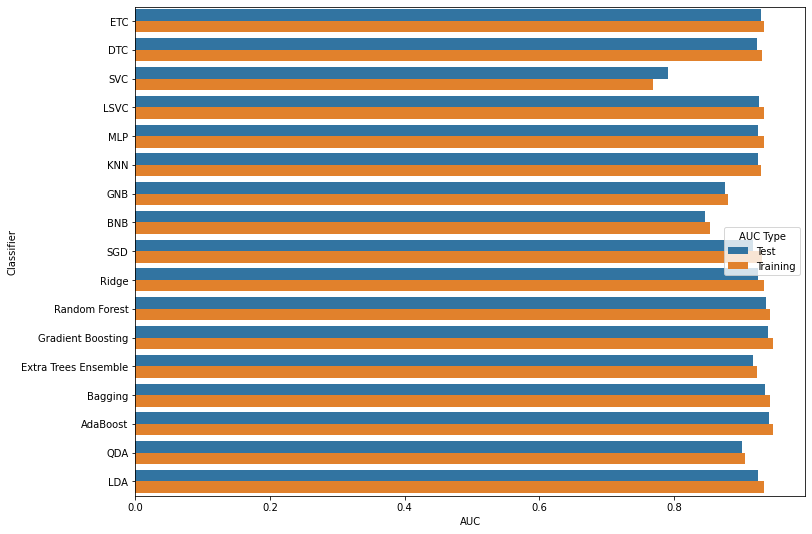

In [62]:
# Set figure size and create barplot
f, ax = plt.subplots(figsize=(12, 9))

sns.barplot(x="AUC", y="Classifier", hue="AUC Type",data=auc_scores)



In [142]:
# Find Classifier which attained max accuracy
max_=0
max_index=None
for row in auc_scores.itertuples(index=True):
    #print(row.AUC)
    if row.AUC > max_ and row._3=='Test':
        max_= row.AUC
        max_index = row.Index
auc_scores[auc_scores.index==max_index]
 

,Classifier,AUC,AUC Type
28,AdaBoost,0.940677,Test


In [153]:
classifiers['AdaBoost'].fit(X_train,np.ravel(y_train))



AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [162]:
classifiers['AdaBoost'].score(X_test,y_test)

0.9127215343529983